In [1]:
import glob
import pandas as pd
from collections import Counter
import re
from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
df = pd.read_csv('../data/processed/mus_musculus/all_mut_mus.csv')

In [3]:
refseq = str(next(SeqIO.parse('../data/raw/mus_musculus/mm10_ChrM_oneline.fasta', 'fasta')).seq)

In [4]:
def add_columns(df:pd.DataFrame):
    
    bp_untill_next_G4 = df['start'].drop(0).values - df['end'].drop(df.shape[0]-1).values
    bp_untill_next_G4 = bp_untill_next_G4.tolist()
    bp_untill_next_G4.append(375)  #375 bp between last G4 and first G4

    bp_untill_previous_G4 = df['start'].drop(0).values - df['end'].drop(df.shape[0]-1).values
    bp_untill_previous_G4 = bp_untill_previous_G4.tolist()
    bp_untill_previous_G4.insert(0, 375) #bp between fist and last

    df['bp_untill_next_G4'] = bp_untill_next_G4
    df['bp_untill_previous_G4'] = bp_untill_previous_G4

    if 'G4_id' in df.columns:
        None
    else:
        df['G4_id'] = [*range(1,df.shape[0]+1)]

    df['up_win'] = pd.concat([df[df['bp_untill_previous_G4'] <= 100][['bp_untill_previous_G4', 'start']]\
                                  .diff(axis=1)['start'],\
                                 df[df['bp_untill_previous_G4'] > 100]['start']-100])
    
    df['down_win'] = pd.concat([df[df['bp_untill_next_G4'] <= 100][['end', 'bp_untill_next_G4']]\
                                    .sum(axis=1), \
                               df[df['bp_untill_next_G4'] > 100]['end']+100])
    return df

In [5]:
def add_columns_10(df:pd.DataFrame): #for category
    df['10_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 10][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 10]['start']-10])
        
    df['10_down'] = pd.concat([df[df['bp_untill_next_G4'] < 10][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 10]['end']+10])
    
    df['20_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 20][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 20]['start']-20])
        
    df['20_down'] = pd.concat([df[df['bp_untill_next_G4'] < 20][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 20]['end']+20])
    
    df['30_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 30][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 30]['start']-30])
        
    df['30_down'] = pd.concat([df[df['bp_untill_next_G4'] < 30][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 30]['end']+30])
    return df

In [8]:
df['gene'].value_counts()

gene
mt-Nd1     22178
mt-Nd4     18772
mt-Nd5     10631
mt-Co1      8232
mt-Cytb     8010
mt-Nd2      5467
mt-Co3      4259
mt-Co2      3023
mt-Atp6     2830
mt-Nd6      2585
mt-Nd4l     1639
mt-Nd3      1436
mt-Atp8      569
Name: count, dtype: int64

## Main table with mutations (Kennedy)
- raw files from https://github.com/Kennedy-Lab-UW/Sanchez_Contreras_etal_2023/blob/main/data/Mouse_aging_mtDNA_summary.csv  
- paper: https://doi.org/10.7554/eLife.83395

In [14]:
outfilename = '../data/processed/mus_musculus/all_mut_mus.txt'

filenames = glob.glob('../data/raw/mus_musculus/Sanchez_Contreras_etal_2023-main/mut_files/*.dcs.mut')

In [15]:
import shutil

with open(outfilename, 'wb') as outfile:
    for filename in filenames:
        if filename == outfilename:
            # don't want to copy the output into the output
            continue
        with open(filename, 'rb') as readfile:
            columns = readfile.readline()
            shutil.copyfileobj(readfile, outfile)

In [16]:
columns = str(columns)[2:-3].split('\\t')

In [17]:
df = pd.read_table(outfilename, header=None)

In [18]:
df.columns = columns

In [19]:
df

,chr,start,end,sample,type,gene,ref,alt,depth,alt_count,VAF,3nt_context,5nt_context,coding_change
0,chrM,55,55,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,11422,1,0.000088,TGT,TTGTA,NaN
1,chrM,153,153,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15166,1,0.000066,ACA,AACAT,NaN
2,chrM,204,204,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,16538,1,0.000060,AGA,AAGAC,NaN
3,chrM,225,225,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15509,1,0.000064,CCC,CCCCC,NaN
4,chrM,302,302,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,T,C,19351,1,0.000052,ATT,AATTT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89626,chrM,15886,15886,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,2971,1,0.000337,CCA,ACCAA,NaN
89627,chrM,15912,15912,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3272,1,0.000306,TGG,TTGGT,NaN
89628,chrM,16012,16012,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3356,1,0.000298,CGC,CCGCA,NaN
89629,chrM,16020,16020,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,3252,1,0.000308,CCA,CCCAA,NaN


In [20]:
df['sample'].str.split('_')

0        [JW21-NP, SS31, C, D247, L191110, 1, S200114]
1        [JW21-NP, SS31, C, D247, L191110, 1, S200114]
2        [JW21-NP, SS31, C, D247, L191110, 1, S200114]
3        [JW21-NP, SS31, C, D247, L191110, 1, S200114]
4        [JW21-NP, SS31, C, D247, L191110, 1, S200114]
                             ...                      
89626       [YM7-MS, NT, R, D240, L191110, 1, S200114]
89627       [YM7-MS, NT, R, D240, L191110, 1, S200114]
89628       [YM7-MS, NT, R, D240, L191110, 1, S200114]
89629       [YM7-MS, NT, R, D240, L191110, 1, S200114]
89630       [YM7-MS, NT, R, D240, L191110, 1, S200114]
Name: sample, Length: 89631, dtype: object

In [21]:
df['MouseID'] = df['sample'].str.split('_').str[0]
df['Treatment'] = df['sample'].str.split('_').str[1]
df['Tissue'] = df['sample'].str.split('_').str[2]

In [22]:
df['Age'] = df['MouseID'].str[0].replace('Y','4.5').replace('[J, O]', '26', regex=True)

In [23]:
df['Mut'] = df['ref'] + '>' + df['alt']

In [24]:
# df.to_csv('../data/processed/mus_musculus/all_mut_mus.csv', index=False)

In [28]:
df

,chr,start,end,sample,type,gene,ref,alt,depth,alt_count,VAF,3nt_context,5nt_context,coding_change,MouseID,Treatment,Tissue,Age,Mut
0,chrM,55,55,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,11422,1,0.000088,TGT,TTGTA,NaN,JW21-NP,SS31,C,26,G>A
1,chrM,153,153,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15166,1,0.000066,ACA,AACAT,NaN,JW21-NP,SS31,C,26,C>T
2,chrM,204,204,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,16538,1,0.000060,AGA,AAGAC,NaN,JW21-NP,SS31,C,26,G>A
3,chrM,225,225,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15509,1,0.000064,CCC,CCCCC,NaN,JW21-NP,SS31,C,26,C>T
4,chrM,302,302,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,T,C,19351,1,0.000052,ATT,AATTT,NaN,JW21-NP,SS31,C,26,T>C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89626,chrM,15886,15886,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,2971,1,0.000337,CCA,ACCAA,NaN,YM7-MS,NT,R,4.5,C>T
89627,chrM,15912,15912,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3272,1,0.000306,TGG,TTGGT,NaN,YM7-MS,NT,R,4.5,G>A
89628,chrM,16012,16012,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3356,1,0.000298,CGC,CCGCA,NaN,YM7-MS,NT,R,4.5,G>A
89629,chrM,16020,16020,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,3252,1,0.000308,CCA,CCCAA,NaN,YM7-MS,NT,R,4.5,C>T


## Collect ALL mutations in intervals around (df_win) and within (df_win_within_sides) G4

In [2]:
df_win = pd.read_csv('../data/processed/mus_musculus/df_win_mm10.csv')
df_win_within_sides = pd.read_csv('../data/processed/mus_musculus/df_win_within_sides_mm10.csv')

In [25]:
Mut_win = []
for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win.append(str(df[(df['start'] == df['end']) & (df['start'].isin(row))].Mut.values))

In [26]:
Mut_win_df = pd.DataFrame(Mut_win)

In [27]:
Mut_win_df[0] = Mut_win_df[0].str.findall("[A-T]>[A-T]")

In [28]:
obsMutwin = pd.DataFrame.from_records(Mut_win_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [29]:
df_win_mus_mut = df_win.join(obsMutwin)

In [30]:
df_win_mus_mut

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
0,1,up,91,106,115,AAATTACACA,6.0,2.0,0.0,2.0,...,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0
1,1,up,90,107,116,AATTACACAT,5.0,2.0,0.0,3.0,...,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0
2,1,up,89,108,117,ATTACACATG,4.0,2.0,1.0,3.0,...,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0
3,1,up,88,109,118,TTACACATGC,3.0,3.0,1.0,3.0,...,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0
4,1,up,87,110,119,TACACATGCA,4.0,3.0,1.0,2.0,...,1.0,2.0,2.0,1.0,7.0,0.0,1.0,0.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,29,down,86,16215,16224,TTTAGTACTT,2.0,1.0,1.0,6.0,...,0.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,3.0,0.0
4755,29,down,87,16216,16225,TTAGTACTTG,2.0,1.0,2.0,5.0,...,0.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,3.0,0.0
4756,29,down,88,16217,16226,TAGTACTTGT,2.0,1.0,2.0,5.0,...,0.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,3.0,0.0
4757,29,down,89,16218,16227,AGTACTTGTA,3.0,1.0,2.0,4.0,...,0.0,2.0,1.0,4.0,6.0,1.0,1.0,0.0,3.0,0.0


In [33]:
# df_win_mus_mut.to_csv('../data/processed/mus_musculus/df_win_mus_mut.csv', index=False)

In [34]:
Mut_win_within_sides = []
for window_start, window_end in zip(df_win_within_sides['window_start'], df_win_within_sides['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win_within_sides.append(str(df[(df['start'] == df['end']) & (df['start'].isin(row))].Mut.values))

In [35]:
Mut_win_df_within_sides = pd.DataFrame(Mut_win_within_sides)

In [36]:
Mut_win_df_within_sides[0] = Mut_win_df_within_sides[0].str.findall("[A-T]>[A-T]")

In [37]:
obsMutwin_within_sides = pd.DataFrame.from_records(Mut_win_df_within_sides[0].apply(lambda x: Counter(x))) \
    .fillna(0) \
    .sort_index(axis=1)

In [38]:
df_win_mus_mut_within_sides = df_win_within_sides.join(obsMutwin_within_sides)

In [39]:
df_win_mus_mut_within_sides

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
0,1,within_start,1,206,215,CACCTTGCCT,1.0,5.0,1.0,3.0,...,0.0,7.0,3.0,3.0,8.0,2.0,2.0,0.0,2.0,0.0
1,1,within_start,2,207,216,ACCTTGCCTA,2.0,4.0,1.0,3.0,...,0.0,5.0,3.0,2.0,8.0,2.0,2.0,0.0,4.0,0.0
2,1,within_start,3,208,217,CCTTGCCTAG,1.0,4.0,2.0,3.0,...,0.0,5.0,3.0,2.0,8.0,2.0,2.0,0.0,4.0,0.0
3,1,within_start,4,209,218,CTTGCCTAGC,1.0,4.0,2.0,3.0,...,0.0,5.0,3.0,0.0,28.0,4.0,12.0,0.0,4.0,0.0
4,1,within_start,5,210,219,TTGCCTAGCC,1.0,4.0,2.0,3.0,...,0.0,3.0,4.0,1.0,28.0,4.0,12.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,29,within_end,43,16078,16087,TTTAACTCTC,2.0,3.0,0.0,5.0,...,2.0,10.0,1.0,12.0,0.0,0.0,0.0,0.0,19.0,1.0
1355,29,within_end,44,16077,16086,TTTTAACTCT,2.0,2.0,0.0,6.0,...,2.0,7.0,1.0,4.0,0.0,0.0,0.0,0.0,19.0,1.0
1356,29,within_end,45,16076,16085,ATTTTAACTC,3.0,2.0,0.0,5.0,...,2.0,7.0,1.0,4.0,0.0,0.0,0.0,0.0,8.0,1.0
1357,29,within_end,46,16075,16084,AATTTTAACT,4.0,1.0,0.0,5.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0


In [41]:
# df_win_mus_mut_within_sides.to_csv('../data/processed/mus_musculus/df_win_mus_mut_within_sides.csv', index=False)

## Collect YOUNG|OLD mutation in intervals separately 

In [4]:
df = pd.read_csv('../data/processed/mus_musculus/all_mut_mus.csv')

In [3]:
df_win = pd.read_csv('../data/processed/mus_musculus/df_win_mm10.csv')
df_win_within_sides = pd.read_csv('../data/processed/mus_musculus/df_win_within_sides_mm10.csv')

In [42]:
Mut_win_y = []
for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win_y.append(str(df[((df['start'] == df['end']) & (df['Age'] == 4.5)) & (df['start'].isin(row))].Mut.values))

In [43]:
Mut_win_o = []
for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win_o.append(str(df[((df['start'] == df['end']) & (df['Age'] == 26)) & (df['start'].isin(row))].Mut.values))

In [44]:
Mut_win_df_y = pd.DataFrame(Mut_win_y)
Mut_win_df_o = pd.DataFrame(Mut_win_o)

In [45]:
Mut_win_df_y[0] = Mut_win_df_y[0].str.findall("[A-T]>[A-T]")
Mut_win_df_o[0] = Mut_win_df_o[0].str.findall("[A-T]>[A-T]")

In [46]:
obsMutwin_y = pd.DataFrame.from_records(Mut_win_df_y[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)
obsMutwin_o = pd.DataFrame.from_records(Mut_win_df_o[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [47]:
df_win_mus_mut_y = df_win.join(obsMutwin_y)
df_win_mus_mut_o = df_win.join(obsMutwin_o)

In [51]:
# df_win_mus_mut_y.to_csv('../data/processed/mus_musculus/df_win_mus_mut_y.csv', index=False)
# df_win_mus_mut_o.to_csv('../data/processed/mus_musculus/df_win_mus_mut_o.csv', index=False)

In [52]:
Mut_win_within_sides_y = []
for window_start, window_end in zip(df_win_within_sides['window_start'], df_win_within_sides['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win_within_sides_y.append(str(df[((df['start'] == df['end']) & (df['Age'] == 4.5)) & (df['start'].isin(row))].Mut.values))

In [53]:
Mut_win_within_sides_o = []
for window_start, window_end in zip(df_win_within_sides['window_start'], df_win_within_sides['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win_within_sides_o.append(str(df[((df['start'] == df['end']) & (df['Age'] == 26)) & (df['start'].isin(row))].Mut.values))

In [54]:
Mut_win_df_within_sides_y = pd.DataFrame(Mut_win_within_sides_y)
Mut_win_df_within_sides_o = pd.DataFrame(Mut_win_within_sides_o)

In [55]:
Mut_win_df_within_sides_y[0] = Mut_win_df_within_sides_y[0].str.findall("[A-T]>[A-T]")
Mut_win_df_within_sides_o[0] = Mut_win_df_within_sides_o[0].str.findall("[A-T]>[A-T]")

In [56]:
obsMutwin_within_sides_y = pd.DataFrame.from_records(Mut_win_df_within_sides_y[0].apply(lambda x: Counter(x))) \
    .fillna(0) \
    .sort_index(axis=1)
obsMutwin_within_sides_o = pd.DataFrame.from_records(Mut_win_df_within_sides_o[0].apply(lambda x: Counter(x))) \
    .fillna(0) \
    .sort_index(axis=1)

In [57]:
df_win_mus_mut_within_sides_y = df_win_within_sides.join(obsMutwin_within_sides_y)
df_win_mus_mut_within_sides_o = df_win_within_sides.join(obsMutwin_within_sides_o)

In [74]:
# add column T>G becaise in data no this transversion
df_win_mus_mut_within_sides_y['T>G'] = 0

In [76]:
# df_win_mus_mut_within_sides_y.to_csv('../data/processed/mus_musculus/df_win_mus_mut_within_sides_y.csv', index=False)
# df_win_mus_mut_within_sides_o.to_csv('../data/processed/mus_musculus/df_win_mus_mut_within_sides_o.csv', index=False)

# PQSfinder

In [6]:
g4pqs = pd.read_csv('../data/raw/mus_musculus/pqsfinder_mtDNA_mus_th15.csv')

In [7]:
g4pqs['G4_id'] = range(1, g4pqs.shape[0]+1)

In [8]:
g4pqs['sequence'] = g4pqs['pattern'].str.replace('[','') \
    .str.replace(']','')\
    .str.replace('(','')\
    .str.replace(')','')\
    .str.upper()

In [9]:
g4pqs.head()

,sequenceName,start,end,score,strand,pattern,nt,nb,nm,rl1,rl2,rl3,ll1,ll2,ll3,G4_id,sequence
0,chrM,904,923,29,-,[C(A)CC]G[CCC]GTCA[CCC]T[CC(T)C],3,2,0,4,3,3,1,4,1,1,CACCGCCCGTCACCCTCCTC
1,chrM,1095,1118,17,-,[C(TAAT)CC]TAG[CCC]TAG[CCC]TA[CaC],3,1,1,7,3,3,3,3,2,2,CTAATCCTAGCCCTAGCCCTACAC
2,chrM,2768,2808,26,-,[CC(TAACACT)CC]TCGT[CCCC]ATTCTAAT[CgCC]ATAG[CC...,4,2,1,11,4,4,4,8,4,3,CCTAACACTCCTCGTCCCCATTCTAATCGCCATAGCCTTCC
3,chrM,3012,3031,30,-,[CCC][C(TA)CC]AATA[CC(A)C]A[CCC],3,2,0,3,5,4,0,4,1,4,CCCCTACCAATACCACACCC
4,chrM,3316,3344,19,-,[CCC]TAGCAGAAA[C(AAA)CC]GGG[CCC][CC(TT)C],3,2,0,3,6,3,9,3,0,5,CCCTAGCAGAAACAAACCGGGCCCCCTTC


#### Statictics for loops

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


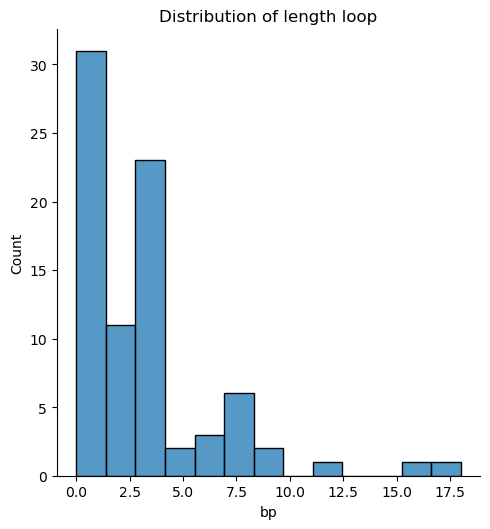

In [12]:
sns.displot(pd.concat([g4pqs['ll1'],g4pqs['ll2'],g4pqs['ll3']])) \
    .set(title='Distribution of length loop', xlabel='bp')

In [14]:
g4pqs['llall'] = g4pqs['ll1'] + g4pqs['ll2'] + g4pqs['ll3']

In [15]:
g4pqs['llall'].describe()

count    27.000000
mean      9.407407
std       5.040293
min       2.000000
25%       5.500000
50%       9.000000
75%      12.500000
max      21.000000
Name: llall, dtype: float64

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


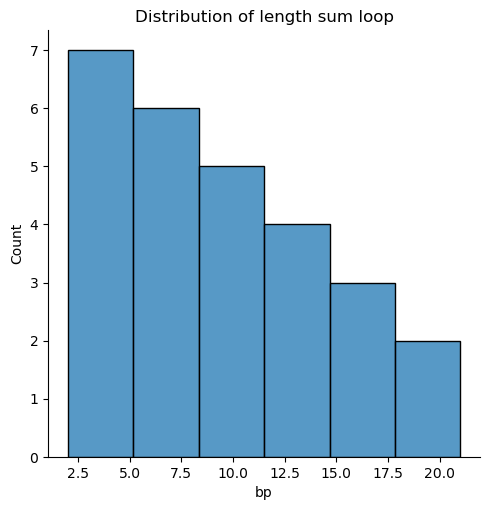

In [17]:
sns.displot(g4pqs['llall']).set(title='Distribution of length sum loop', xlabel='bp')

In [19]:
# intervals around have to be 9-10bp
# choose 10bp

### pqs add category

In [10]:
nuc_positions = []
for seq, start, G4_id in zip(g4pqs['sequence'], g4pqs['start'], g4pqs['G4_id']):
    for (i, j), (x, y) in zip(enumerate(seq, start=start), enumerate(seq)):
        row = [G4_id,x,i,j]
        nuc_positions.append(row)

In [11]:
nuc_positions = pd.DataFrame(nuc_positions, columns=['G4_id', 'pos_in_seq', 'pos_in_ref', 'nuc'])

In [12]:
nuc_positions.head()

,G4_id,pos_in_seq,pos_in_ref,nuc
0,1,0,904,C
1,1,1,905,A
2,1,2,906,C
3,1,3,907,C
4,1,4,908,G


In [13]:
def categorize_sequence(sequence):  
    pattern = r'\[[A-Z]+\]|\([A-Z]+\)|\[[A-Z]+|[A-Z]+\]|[A-Z]+|[a-z]+'
    
    matches = re.findall(pattern, sequence)
    categories = []
    
    for match in matches:
        # print(match)
        if match.startswith('[') or match.endswith(']'):
            categories.extend(['Tetrad'] * len(match))
        elif match.startswith('(') and match.endswith(')'):
            categories.extend(['Bulges'] * len(match))
        elif match.isupper():
            categories.extend(['Loop'] * len(match))
        elif match.islower():
            categories.extend(['Mismatch'] * len(match))
    
    char_result = [char for char in sequence]

    return char_result, categories

In [14]:
df_category = pd.DataFrame.from_records(g4pqs['pattern'].apply(categorize_sequence), 
                          columns=['char', 'category']) \
    .explode(['char', 'category']) \
    .reset_index(drop=True)

In [15]:
df_category.head()

,char,category
0,[,Tetrad
1,C,Tetrad
2,(,Bulges
3,A,Bulges
4,),Bulges


In [16]:
df_category = df_category[~df_category['char'].isin(['[', ']', '(', ')'])].reset_index(drop=True)

In [17]:
df_category['char'] = df_category['char'].str.upper()

In [18]:
df_category = nuc_positions.join(df_category).drop('char', axis=1)

In [19]:
df_category.head()

,G4_id,pos_in_seq,pos_in_ref,nuc,category
0,1,0,904,C,Tetrad
1,1,1,905,A,Bulges
2,1,2,906,C,Tetrad
3,1,3,907,C,Tetrad
4,1,4,908,G,Loop


In [20]:
# df_category.to_csv('../data/processed/mus_musculus/df_category_pqs_mus.csv', index=False)

In [32]:
# next choose only loops:

data_loops = []
for G4_id in df_category[df_category['category'] == 'Loop']['G4_id'].unique():
    row = []
    positions = df_category[(df_category['category'] == 'Loop') & (df_category['G4_id'] == G4_id)]['pos_in_ref'].values.tolist()
    seq = ''.join(df_category[(df_category['category'] == 'Loop') & (df_category['G4_id'] == G4_id)]['nuc'].values)

    row.append(G4_id)
    row.append('loops')
    row.append(positions)
    row.append(seq)
    data_loops.append(row)

In [33]:
data_loops = pd.DataFrame(data=data_loops, columns = ['G4_id', 'side', 'positions', 'sequence'])
nuc_count = data_loops['sequence'].apply(lambda x: Counter(x))
nuc_count = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)
data_loops = data_loops.join(nuc_count).fillna(0)

In [34]:
data_loops.head()

,G4_id,side,positions,sequence,A,C,G,T
0,1,loops,"[908, 912, 913, 914, 915, 919]",GGTCAT,1.0,1.0,2.0,2.0
1,2,loops,"[1102, 1103, 1104, 1108, 1109, 1110, 1114, 1115]",TAGTAGTA,3.0,0.0,2.0,3.0
2,3,loops,"[2779, 2780, 2781, 2782, 2787, 2788, 2789, 279...",TCGTATTCTAATATAG,5.0,2.0,2.0,7.0
3,4,loops,"[3020, 3021, 3022, 3023, 3028]",AATAA,4.0,0.0,0.0,1.0
4,5,loops,"[3319, 3320, 3321, 3322, 3323, 3324, 3325, 332...",TAGCAGAAAGGG,5.0,1.0,5.0,1.0


In [36]:
# data_loops.to_csv('../data/processed/mus_musculus/data_loops_pqs_mus.csv', index=False)

In [21]:
df_category = pd.read_csv('../data/processed/mus_musculus/df_category_pqs_mus.csv')

In [8]:
data_tetrads = []
for G4_id in df_category[df_category['category'].isin(['Tetrad', 'Mismatch'])]['G4_id'].unique():
    row = []
    positions = df_category[(df_category['category'].isin(['Tetrad', 'Mismatch'])) & (df_category['G4_id'] == G4_id)]['pos_in_ref'].values.tolist()
    seq = ''.join(df_category[(df_category['category'].isin(['Tetrad', 'Mismatch'])) & (df_category['G4_id'] == G4_id)]['nuc'].values)

    row.append(G4_id)
    row.append('tetrads')
    row.append(positions)
    row.append(seq)
    data_tetrads.append(row)

In [9]:
data_tetrads = pd.DataFrame(data=data_tetrads, columns = ['G4_id', 'side', 'positions', 'sequence'])
nuc_count = data_tetrads['sequence'].apply(lambda x: Counter(x))
nuc_count = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)
data_tetrads = data_tetrads.join(nuc_count).fillna(0)

In [10]:
data_tetrads.head()

,G4_id,side,positions,sequence,A,C,G,T
0,1,tetrads,"[904, 906, 907, 909, 910, 911, 916, 917, 918, ...",CCCCCCCCCCCC,0.0,12.0,0.0,0.0
1,2,tetrads,"[1095, 1100, 1101, 1105, 1106, 1107, 1111, 111...",CCCCCCCCCCAC,1.0,11.0,0.0,0.0
2,3,tetrads,"[2768, 2769, 2777, 2778, 2783, 2784, 2785, 278...",CCCCCCCCCGCCCCCC,0.0,15.0,1.0,0.0
3,4,tetrads,"[3012, 3013, 3014, 3015, 3018, 3019, 3024, 302...",CCCCCCCCCCCC,0.0,12.0,0.0,0.0
4,5,tetrads,"[3316, 3317, 3318, 3328, 3332, 3333, 3337, 333...",CCCCCCCCCCCC,0.0,12.0,0.0,0.0


In [12]:
# data_tetrads.to_csv('../data/processed/mus_musculus/data_tetrads_pqs_mus.csv', index=False)

In [51]:
g4pqs.head()

,sequenceName,start,end,score,strand,pattern,nt,nb,nm,rl1,rl2,rl3,ll1,ll2,ll3,G4_id,sequence
0,chrM,904,923,29,-,[C(A)CC]G[CCC]GTCA[CCC]T[CC(T)C],3,2,0,4,3,3,1,4,1,1,CACCGCCCGTCACCCTCCTC
1,chrM,1095,1118,17,-,[C(TAAT)CC]TAG[CCC]TAG[CCC]TA[CaC],3,1,1,7,3,3,3,3,2,2,CTAATCCTAGCCCTAGCCCTACAC
2,chrM,2768,2808,26,-,[CC(TAACACT)CC]TCGT[CCCC]ATTCTAAT[CgCC]ATAG[CC...,4,2,1,11,4,4,4,8,4,3,CCTAACACTCCTCGTCCCCATTCTAATCGCCATAGCCTTCC
3,chrM,3012,3031,30,-,[CCC][C(TA)CC]AATA[CC(A)C]A[CCC],3,2,0,3,5,4,0,4,1,4,CCCCTACCAATACCACACCC
4,chrM,3316,3344,19,-,[CCC]TAGCAGAAA[C(AAA)CC]GGG[CCC][CC(TT)C],3,2,0,3,6,3,9,3,0,5,CCCTAGCAGAAACAAACCGGGCCCCCTTC


In [52]:
g4pqs = add_columns(g4pqs)

In [53]:
g4pqs.head()

,sequenceName,start,end,score,strand,pattern,nt,nb,nm,rl1,...,rl3,ll1,ll2,ll3,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win
0,chrM,904,923,29,-,[C(A)CC]G[CCC]GTCA[CCC]T[CC(T)C],3,2,0,4,...,3,1,4,1,1,CACCGCCCGTCACCCTCCTC,172,375,804,1023
1,chrM,1095,1118,17,-,[C(TAAT)CC]TAG[CCC]TAG[CCC]TA[CaC],3,1,1,7,...,3,3,3,2,2,CTAATCCTAGCCCTAGCCCTACAC,1650,172,995,1218
2,chrM,2768,2808,26,-,[CC(TAACACT)CC]TCGT[CCCC]ATTCTAAT[CgCC]ATAG[CC...,4,2,1,11,...,4,4,8,4,3,CCTAACACTCCTCGTCCCCATTCTAATCGCCATAGCCTTCC,204,1650,2668,2908
3,chrM,3012,3031,30,-,[CCC][C(TA)CC]AATA[CC(A)C]A[CCC],3,2,0,3,...,4,0,4,1,4,CCCCTACCAATACCACACCC,285,204,2912,3131
4,chrM,3316,3344,19,-,[CCC]TAGCAGAAA[C(AAA)CC]GGG[CCC][CC(TT)C],3,2,0,3,...,3,9,3,0,5,CCCTAGCAGAAACAAACCGGGCCCCCTTC,561,285,3216,3444


In [54]:
g4pqs = add_columns_10(g4pqs).fillna(0)

In [94]:
# g4pqs.to_csv('../data/processed/mus_musculus/g4pqs_mus.csv', index=False)

In [69]:
def make_10_col(df:pd.DataFrame, column_10:str, start_or_end:str, up=True):
    data_up = []
    for up_10, start, G4_id in zip(df[column_10], df[start_or_end], df['G4_id']):
        if up_10 > 0:
            row = []
            seq = ''
            if up == True:
                window = [*range(int(up_10), int(start))]
            elif up == False:
                window = [*range(int(start), int(up_10))]
            
            for pos in window:
                seq += str(refseq[pos])
                
            row.append(G4_id)
            row.append(column_10)
            if up == True:
                row.append(int(up_10))
                row.append(int(start))
            elif up == False:    
                row.append(int(start))
                row.append(int(up_10))
            row.append(seq)
    
            data_up.append(row)
        else:
            continue
    return data_up

In [70]:
data_10_col = make_10_col(g4pqs, '10_up', 'start', up=True) + \
make_10_col(g4pqs, '20_up', '10_up', up=True) + \
make_10_col(g4pqs, '30_up', '20_up', up=True) + \
make_10_col(g4pqs, '10_down', 'end', up=False) + \
make_10_col(g4pqs, '20_down', '10_down', up=False) + \
make_10_col(g4pqs, '30_down', '20_down', up=False)

In [71]:
data_10_col = pd.DataFrame(data=data_10_col, columns = ['G4_id', 'side', 'window_start', 'window_end', 'sequence'])
nuc_count_10 = data_10_col['sequence'].apply(lambda x: Counter(x))
nuc_count_10 = pd.DataFrame.from_records(nuc_count_10).sort_index(axis=1)
data_10_col = data_10_col.join(nuc_count_10).fillna(0)

In [72]:
data_10_col

,G4_id,side,window_start,window_end,sequence,A,C,G,T
0,1,10_up,894,904,GTACGCACAC,3.0,4.0,2.0,1.0
1,2,10_up,1085,1095,CACTCTGAAC,3.0,4.0,1.0,2.0
2,3,10_up,2758,2768,TATTAATATC,4.0,1.0,0.0,5.0
3,4,10_up,3002,3012,CTATGAGTTC,2.0,2.0,2.0,4.0
4,5,10_up,3306,3316,TTATCTCAAC,3.0,3.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...
151,22,30_down,13985,13995,CTCCATAAAT,4.0,3.0,0.0,3.0
152,23,30_down,14963,14973,TTCCTATTTG,1.0,2.0,1.0,6.0
153,24,30_down,15411,15421,ACTACTTCTT,2.0,3.0,0.0,5.0
154,26,30_down,15751,15761,TAAACTTGGG,3.0,1.0,3.0,3.0


In [74]:
# data_10_col.to_csv('../data/processed/mus_musculus/data_10_col_pqs_mus.csv', index=False)

### Collect mutations pqs

In [13]:
data_10_col = pd.read_csv('../data/processed/mus_musculus/data_10_col_pqs_mus.csv')
data_loops = pd.read_csv('../data/processed/mus_musculus/data_loops_pqs_mus.csv')
data_tetrads = pd.read_csv('../data/processed/mus_musculus/data_tetrads_pqs_mus.csv')

In [32]:
def collect_mut(df_mut:pd.DataFrame, df_win:pd.DataFrame, regime:str):
    if regime == '2col':
        Mut_win = []
        for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
            row = [*range(window_start, window_end)]
            Mut_win.append(str(df_mut[(df_mut['start'] == df_mut['end']) & (df_mut['start'].isin(row))].Mut.values))
    elif regime == '1col':
        Mut_win = []
        for row in df_win['positions']:
            Mut_win.append(str(df_mut[(df_mut['start'].isin( \
                list(map(int, row.strip('[]').replace(' ', '').split(','))) \
                                                                )) & (df_mut['end'].isin( \
                list(map(int, row.strip('[]').replace(' ', '').split(','))) \
                                                                ))].Mut.values))
            
    elif regime == 'pos':
        Mut_win = []
        for i in df_win['pos_in_ref']:
            Mut_win.append(str(df_mut[(df_mut['start'] == i) & (df_mut['end'] == i)].Mut.values))
    
    Mut_win_df = pd.DataFrame(Mut_win)
    Mut_win_df[0] = Mut_win_df[0].str.findall("[A-T]>[A-T]")
    obsMutwin = pd.DataFrame.from_records(Mut_win_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)
    df_win_mut = df_win.join(obsMutwin)

    mutations = ['A>C','A>G','A>T',
                 'C>A','C>G','C>T',
                 'G>A','G>C','G>T',
                 'T>A','T>C','T>G']
    for mutation in mutations:
        if mutation not in df_win_mut.columns:
            df_win_mut[mutation] = 0
        else:
            continue
    
    df_win_mut['number_of_Mut'] = df_win_mut[['A>C','A>G','A>T',
                                                    'C>A','C>G','C>T',
                                                'G>A','G>C','G>T',
                                                'T>A','T>C','T>G']].sum(axis=1)
    return df_win_mut

In [80]:
df

,chr,start,end,sample,type,gene,ref,alt,depth,alt_count,VAF,3nt_context,5nt_context,coding_change,MouseID,Treatment,Tissue,Age,Mut
0,chrM,55,55,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,11422,1,0.000088,TGT,TTGTA,NaN,JW21-NP,SS31,C,26.0,G>A
1,chrM,153,153,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15166,1,0.000066,ACA,AACAT,NaN,JW21-NP,SS31,C,26.0,C>T
2,chrM,204,204,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,16538,1,0.000060,AGA,AAGAC,NaN,JW21-NP,SS31,C,26.0,G>A
3,chrM,225,225,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15509,1,0.000064,CCC,CCCCC,NaN,JW21-NP,SS31,C,26.0,C>T
4,chrM,302,302,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,T,C,19351,1,0.000052,ATT,AATTT,NaN,JW21-NP,SS31,C,26.0,T>C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89626,chrM,15886,15886,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,2971,1,0.000337,CCA,ACCAA,NaN,YM7-MS,NT,R,4.5,C>T
89627,chrM,15912,15912,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3272,1,0.000306,TGG,TTGGT,NaN,YM7-MS,NT,R,4.5,G>A
89628,chrM,16012,16012,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3356,1,0.000298,CGC,CCGCA,NaN,YM7-MS,NT,R,4.5,G>A
89629,chrM,16020,16020,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,3252,1,0.000308,CCA,CCCAA,NaN,YM7-MS,NT,R,4.5,C>T


In [84]:
df_loop_mut_mus = collect_mut(df_mut=df, df_win=data_loops, regime='1col')

In [90]:
df_10_col_mut = collect_mut(df_mut=df, df_win=data_10_col, regime='2col')

In [17]:
df_tetrads_mut_mus = collect_mut(df_mut=df, df_win=data_tetrads, regime='1col')

In [19]:
# df_tetrads_mut_mus

In [24]:
# df_loop_mut_mus.to_csv('../data/processed/mus_musculus/df_loop_mut_pqs_mus.csv', index=False)
# df_10_col_mut.to_csv('../data/processed/mus_musculus/df_10_col_mut_pqs_mus.csv', index=False)
# df_tetrads_mut_mus.to_csv('../data/processed/mus_musculus/df_tetrads_mut_pqs_mus.csv', index=False)

# Data preparation within category, mus. PQS

In [22]:
df_category = pd.read_csv('../data/processed/mus_musculus/df_category_pqs_mus.csv')

In [33]:
df_category_mus_mut = collect_mut(df_mut=df, df_win=df_category, regime='pos')

In [34]:
df_category_mus_mut

,G4_id,pos_in_seq,pos_in_ref,nuc,category,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,0,904,C,Tetrad,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,1,1,905,A,Bulges,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,1,2,906,C,Tetrad,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,1,3,907,C,Tetrad,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,1,4,908,G,Loop,0.0,0.0,0.0,0.0,0.0,0.0,25.0,1.0,3.0,0.0,0.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,27,32,16120,A,Loop,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
777,27,33,16121,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,27,34,16122,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,27,35,16123,C,Tetrad,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [36]:
# df_category_mus_mut.to_csv('../data/processed/df_category_mus_mut.csv', index=False)

# Prepare for count common mutspec

In [18]:
refseq

'GTTAATGTAGCTTAATAACAAAGCAAAGCACTGAAAATGCTTAGATGGATAATTGTATCCCATAAACACAAAGGTTTGGTCCTGGCCTTATAATTAATTAGAGGTAAAATTACACATGCAAACCTCCATAGACCGGTGTAAAATCCCTTAAACATTTACTTAAAATTTAAGGAGAGGGTATCAAGCACATTAAAATAGCTTAAGACACCTTGCCTAGCCACACCCCCACGGGACTCAGCAGTGATAAATATTAAGCAATAAACGAAAGTTTGACTAAGTTATACCTCTTAGGGTTGGTAAATTTCGTGCCAGCCACCGCGGTCATACGATTAACCCAAACTAATTATCTTCGGCGTAAAACGTGTCAACTATAAATAAATAAATAGAATTAAAATCCAACTTATATGTGAAAATTCATTGTTAGGACCTAAACTCAATAACGAAAGTAATTCTAGTCATTTATAATACACGACAGCTAAGACCCAAACTGGGATTAGATACCCCACTATGCTTAGCCATAAACCTAAATAATTAAATTTAACAAAACTATTTGCCAGAGAACTACTAGCCATAGCTTAAAACTCAAAGGACTTGGCGGTACTTTATATCCATCTAGAGGAGCCTGTTCTATAATCGATAAACCCCGCTCTACCTCACCATCTCTTGCTAATTCAGCCTATATACCGCCATCTTCAGCAAACCCTAAAAAGGTATTAAAGTAAGCAAAAGAATCAAACATAAAAACGTTAGGTCAAGGTGTAGCCAATGAAATGGGAAGAAATGGGCTACATTTTCTTATAAAAGAACATTACTATACCCTTTATGAAACTAAAGGACTAAGGAGGATTTAGTAGTAAATTAAGAATAGAGAGCTTAATTGAATTGAGCAATGAAGTACGCACACACCGCCCGTCACCCTCCTCAAATTAAATTAAACTTAACATAATTAATTTCTAGACATCCGTTTATGAGAGGAGATAAGTCGTAACAAGGTAAGCA

In [19]:
df = pd.read_csv('../data/processed/mus_musculus/all_mut_mus.csv')

In [21]:
df['gene'].value_counts()

gene
mt-Nd1     22178
mt-Nd4     18772
mt-Nd5     10631
mt-Co1      8232
mt-Cytb     8010
mt-Nd2      5467
mt-Co3      4259
mt-Co2      3023
mt-Atp6     2830
mt-Nd6      2585
mt-Nd4l     1639
mt-Nd3      1436
mt-Atp8      569
Name: count, dtype: int64

In [25]:
df

,chr,start,end,sample,type,gene,ref,alt,depth,alt_count,VAF,3nt_context,5nt_context,coding_change,MouseID,Treatment,Tissue,Age,Mut
0,chrM,55,55,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,11422,1,0.000088,TGT,TTGTA,NaN,JW21-NP,SS31,C,26.0,G>A
1,chrM,153,153,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15166,1,0.000066,ACA,AACAT,NaN,JW21-NP,SS31,C,26.0,C>T
2,chrM,204,204,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,G,A,16538,1,0.000060,AGA,AAGAC,NaN,JW21-NP,SS31,C,26.0,G>A
3,chrM,225,225,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,C,T,15509,1,0.000064,CCC,CCCCC,NaN,JW21-NP,SS31,C,26.0,C>T
4,chrM,302,302,JW21-NP_SS31_C_D247_L191110_1_S200114,5'Flank,mt-Nd1,T,C,19351,1,0.000052,ATT,AATTT,NaN,JW21-NP,SS31,C,26.0,T>C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89626,chrM,15886,15886,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,2971,1,0.000337,CCA,ACCAA,NaN,YM7-MS,NT,R,4.5,C>T
89627,chrM,15912,15912,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3272,1,0.000306,TGG,TTGGT,NaN,YM7-MS,NT,R,4.5,G>A
89628,chrM,16012,16012,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,G,A,3356,1,0.000298,CGC,CCGCA,NaN,YM7-MS,NT,R,4.5,G>A
89629,chrM,16020,16020,YM7-MS_NT_R_D240_L191110_1_S200114,3'Flank,mt-Nd4,C,T,3252,1,0.000308,CCA,CCCAA,NaN,YM7-MS,NT,R,4.5,C>T
